In [7]:
# Library
from base import S1_CENTERS_FILE
from pandas import read_csv, DataFrame
from tqdm import tqdm

MS_BANDWIDTH = 2.942783814571208
MAX_DISTANCE_QUANTILE = 85

# Read Data
triangles:DataFrame = read_csv(S1_CENTERS_FILE)


In [8]:
# #############################################################################
# Algo
# #############################################################################
from sklearn.cluster import MeanShift, estimate_bandwidth
from numpy import percentile, array
from pandas import DataFrame, Series

# Get Just the centers
triangle_centers = triangles[['centroid_x','centroid_y','centroid_z']].as_matrix()

# Compute bandwidth for clustering with MeanShift
bandwidth = estimate_bandwidth(triangle_centers, quantile=0.025, n_samples=200)

# clustering with MeanShift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(triangle_centers)

# Grab Cluster Labels
triangles['ms_middle'] = Series(ms.labels_, index=triangles.index)

# Attach Cluster Centers
centers_and_clusters = triangles.merge( 
    DataFrame(ms.cluster_centers_, columns=['ms_x','ms_y','ms_z']), 
    left_on='ms_middle', 
    right_index=True 
)

In [25]:
merge(
    DataFrame([i for i in range(0,len(ms.cluster_centers_))], columns=['ms_label']),
    DataFrame(ms.cluster_centers_, columns=['x','y','z']),
    left_index=True, right_index=True
).to_csv(S2_CLUSTER_ALGO_FILE, index=False)
centers_and_clusters.to_csv(S2_CLUSTERS_FILE, index=False)

In [6]:
# Compute Distances
cx = centers_and_clusters['centroid_x']
cy = centers_and_clusters['centroid_y']
cz = centers_and_clusters['centroid_z']

msx = centers_and_clusters['ms_x']
msy = centers_and_clusters['ms_y']
msz = centers_and_clusters['ms_z']

# Get Ready to plot
distances = DataFrame({
    'ms_dist': (((cx-msx)**2) + ((cy-msy)**2)  + ((cz-msz)**2))**0.5,
    'ms_middle': centers_and_clusters['ms_middle']
})
size = distances.groupby(['ms_middle'])['ms_dist'].max()

colors = array(['blue'] * len(size))
colors[size > percentile(size, q = MAX_DISTANCE_QUANTILE)] = 'red'

size = 1000*size/max(size)


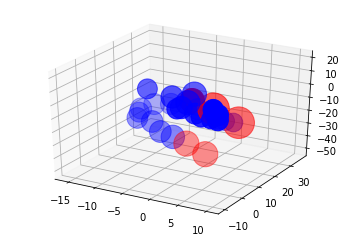

In [8]:
# Plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure, show

fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter( ms.cluster_centers_[:,0], ms.cluster_centers_[:,1], ms.cluster_centers_[:,2], s=size, c=colors )


In [1]:
# Library
from base import S2_CLUSTERS_FILE, S2_CLUSTER_ALGO_FILE
from pandas import read_csv, DataFrame
from numpy import array, percentile
from tqdm import tqdm

# ARBITRARY CONSTANTS 
# need more work to figure optimal points, 
# at the moment these are manually set
MAX_DISTANCE_QUANTILE = 85

# Read Data
centers_and_clusters:DataFrame = read_csv(S2_CLUSTERS_FILE)
cluster_labels:DataFrame = read_csv(S2_CLUSTER_ALGO_FILE)

# #############################################################################
# Compute Distances
# #############################################################################
# Grab Vectors
cx = centers_and_clusters['centroid_x']
cy = centers_and_clusters['centroid_y']
cz = centers_and_clusters['centroid_z']

msx = centers_and_clusters['ms_x']
msy = centers_and_clusters['ms_y']
msz = centers_and_clusters['ms_z']


# Calculate
distances = DataFrame({
    'ms_dist': (((cx-msx)**2) + ((cy-msy)**2)  + ((cz-msz)**2))**0.5,
    'ms_label': centers_and_clusters['ms_label']
})
size = distances.groupby(['ms_label'])['ms_dist'].max()


In [15]:
# #############################################################################
# Calculate Sub Groups
# #############################################################################
chosen_groups = cluster_labels['ms_label'][size > percentile(size, q = MAX_DISTANCE_QUANTILE)].tolist()

chosen_centers_and_clusters = centers_and_clusters.loc[[ j in chosen_groups for j in centers_and_clusters['ms_label'] ]][['centroid_x','centroid_y','centroid_z','ms_label']]


In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure, show

fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter( 
    chosen_centers_and_clusters['centroid_x'],
    chosen_centers_and_clusters['centroid_y'],
    chosen_centers_and_clusters['centroid_z'],
)